# DeepChem library import and environment setup

In [ ]:
!pip install tf_keras

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [ ]:
!pip install DeepChem

In [ ]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from deepchem.models import GraphConvModel


In [ ]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from tqdm.auto import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# DUD-E active dataset upload


In [ ]:
# URL for COX-2 benchmark set in DUD-E database
url = 'http://dude.docking.org/targets/ada17/actives_final.ism'

# Load data into pandas DataFrame
active_df = pd.read_csv(url, sep=' ', header=None)

In [ ]:
active_df.shape

(532, 3)

In [ ]:
active_df[:5]

,0,1,2
0,Cc4cc(COc2ccc(C(=O)NC1(C)C(=O)NC(=O)NC1=O)cc2)...,410227,CHEMBL391851
1,C[C@@H](N4CC[C@@](C)(c3ccc(OCc1cc(C)nc2ccccc12...,243180,CHEMBL148169
2,Cc5cc(COc3ccc(NC(=O)[C@H]2CCN(C(=O)c1ccco1)C[C...,225277,CHEMBL343548
3,Fc5ccc4CN(C[C@@]3(c2ccc(c1c[nH]c(=O)c(Cl)c1)cc...,689383,CHEMBL1222942
4,Cc4cc(COc2ccc(C(=O)N[C@@H]1CN(CC#C)C[C@@H]1C(=...,438292,CHEMBL271235


In [ ]:
active_rows, active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")

,SMILES,ID,ChEMBL_ID,label,Mol
0,Cc4cc(COc2ccc(C(=O)NC1(C)C(=O)NC(=O)NC1=O)cc2)...,410227,CHEMBL391851,Active,
1,C[C@@H](N4CC[C@@](C)(c3ccc(OCc1cc(C)nc2ccccc12...,243180,CHEMBL148169,Active,
2,Cc5cc(COc3ccc(NC(=O)[C@H]2CCN(C(=O)c1ccco1)C[C...,225277,CHEMBL343548,Active,
3,Fc5ccc4CN(C[C@@]3(c2ccc(c1c[nH]c(=O)c(Cl)c1)cc...,689383,CHEMBL1222942,Active,
4,Cc4cc(COc2ccc(C(=O)N[C@@H]1CN(CC#C)C[C@@H]1C(=...,438292,CHEMBL271235,Active,
...,...,...,...,...,...
527,COC(=O)[C@]3(c2cccc(OCC1CCCCC1)c2)C[C@H]3C(=O)NO,441569,CHEMBL270063,Active,
528,CN(Cc1cccnc1)C(=O)[C@H](O)[C@@H](O)C(=O)NCCc2c...,599486,CHEMBL600680,Active,
529,ONC(=O)[C@H]2Cc1nccnc1CN2S(=O)(=O)c3cccs3,275901,CHEMBL167846,Active,
530,CC#CCOc5ccc(S(=O)(=O)N[C@@H](Cc3cn(Cc1ccccc1c2...,523405,CHEMBL452642,Active,

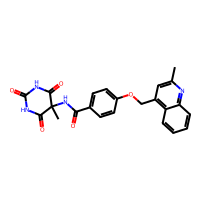
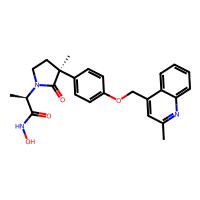
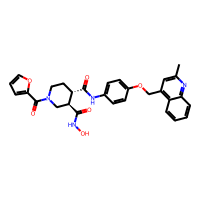
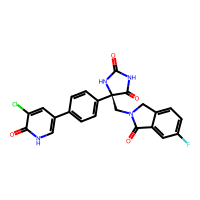
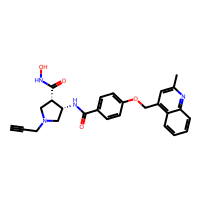
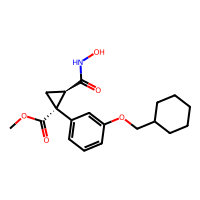
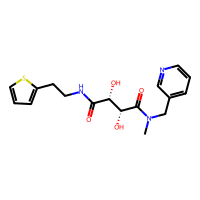
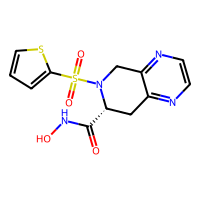
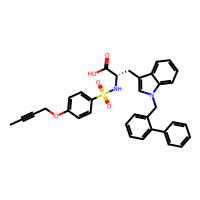
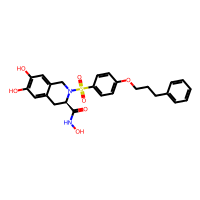

In [ ]:
active_df

## Molecular features extraction

In [ ]:
from rdkit.Chem import Descriptors, rdmolops

def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]
    df_in["num_hbd"] = [Descriptors.NumHDonors(mol) for mol in df_in.Mol]
    df_in["num_hba"] = [Descriptors.NumHAcceptors(mol) for mol in df_in.Mol]
    df_in["tpsa"] = [Descriptors.TPSA(mol) for mol in df_in.Mol]
    df_in["num_rotatable"] = [Descriptors.NumRotatableBonds(mol) for mol in df_in.Mol]

In [ ]:
add_property_columns_to_df(active_df)
active_df.head()

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge,num_hbd,num_hba,tpsa,num_rotatable
0,Cc4cc(COc2ccc(C(=O)NC1(C)C(=O)NC(=O)NC1=O)cc2)...,410227,CHEMBL391851,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c0200>,432.436,1.97672,0,3,6,126.49,5
1,C[C@@H](N4CC[C@@](C)(c3ccc(OCc1cc(C)nc2ccccc12...,243180,CHEMBL148169,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c0270>,433.508,3.50612,0,2,5,91.76,6
2,Cc5cc(COc3ccc(NC(=O)[C@H]2CCN(C(=O)c1ccco1)C[C...,225277,CHEMBL343548,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c02e0>,528.565,3.93762,0,3,7,134.00,7
3,Fc5ccc4CN(C[C@@]3(c2ccc(c1c[nH]c(=O)c(Cl)c1)cc...,689383,CHEMBL1222942,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c00b0>,466.856,2.52510,0,3,4,111.37,4
4,Cc4cc(COc2ccc(C(=O)N[C@@H]1CN(CC#C)C[C@@H]1C(=...,438292,CHEMBL271235,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c0510>,458.518,2.29102,0,3,6,103.79,7


## DUD-E decoy dataset

In [ ]:
url2 = 'http://dude.docking.org/targets/ada17/decoys_final.ism'
decoy_df = pd.read_csv(url2, sep=' ', header=None)
decoy_df[:3]

,0,1
0,c1ccc(cc1)/N=N/c2ccc3cc(ccc3c2/N=N/c4ccc(cc4)O...,C03844583
1,c1cc(ccc1COc2ccc(cc2I)/C=C/3\C(=O)NC(=O)S3)C(=...,C02959287
2,CC(C)[C@@H](C(=O)[O-])N1C(=O)/C(=C/2\c3cc(ccc3...,C01235888


In [ ]:
print(len(decoy_df))

35900


In [ ]:
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

,SMILES,ID,label,Mol,mw,logP,charge,num_hbd,num_hba,tpsa,num_rotatable
0,c1ccc(cc1)/N=N/c2ccc3cc(ccc3c2/N=N/c4ccc(cc4)O...,C03844583,Decoy,,431.453,6.28030,-1,1,8,126.87,5
1,c1cc(ccc1COc2ccc(cc2I)/C=C/3\C(=O)NC(=O)S3)C(=...,C02959287,Decoy,,480.259,2.55760,-1,1,6,95.53,5
2,CC(C)[C@@H](C(=O)[O-])N1C(=O)/C(=C/2\c3cc(ccc3...,C01235888,Decoy,,440.320,1.74710,-1,1,6,89.54,3
3,CCOc1cc(c(c(c1O)Br)Br)/C=C/2\C(=O)N(C(=S)S2)CC...,C09296616,Decoy,,496.178,2.26700,-1,1,7,89.90,5
4,c1cc(cc(c1)Br)/C=C\2/C(=O)N(C(=S)S2)CCC(=O)Nc3...,C01239506,Decoy,,490.380,3.04260,-1,1,6,89.54,6
...,...,...,...,...,...,...,...,...,...,...,...
35895,CC(C)NS(=O)(=O)c1cccc(c1)C(=O)NCc2nc(on2)c3ccsc3,C58264343,Decoy,,406.489,2.41480,0,2,7,114.19,7
35896,COC(=O)C[C@@H](c1ccccc1Cl)NC(=O)NCc2ccnc(c2)n3...,C28378968,Decoy,,413.865,3.02430,0,2,6,98.14,7
35897,c1cc(cc(c1)N2CCCC2=O)NC(=O)CCSc3[nH]nc(n3)c4cc...,C59885358,Decoy,,408.487,3.11440,0,2,6,103.87,7
35898,COc1ccc(cc1OC)[C@H]2CCC(=O)N(N2)CC(=O)NC3=C[C@...,C64435628,Decoy,,408.458,1.82120,0,2,6,92.26,6

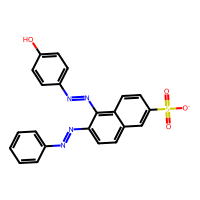
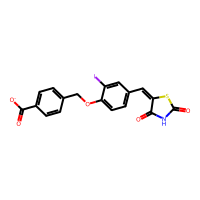
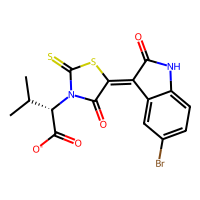
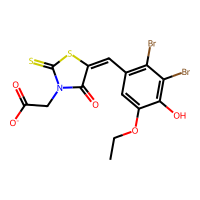
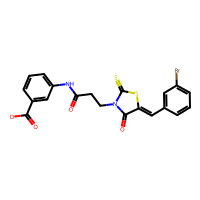
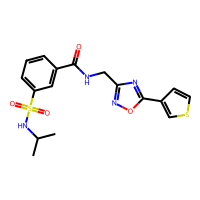
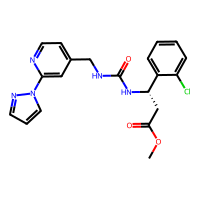
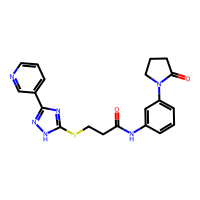
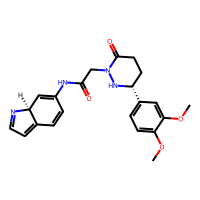
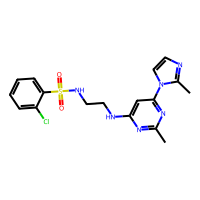

In [ ]:
decoy_df.head

## Complete dataset

In [ ]:
tmp_df = pd.concat([active_df, decoy_df])
tmp_df.shape

(36432, 12)

In [ ]:
tmp_df.head()

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge,num_hbd,num_hba,tpsa,num_rotatable
0,Cc4cc(COc2ccc(C(=O)NC1(C)C(=O)NC(=O)NC1=O)cc2)...,410227,CHEMBL391851,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c0200>,432.436,1.97672,0,3,6,126.49,5
1,C[C@@H](N4CC[C@@](C)(c3ccc(OCc1cc(C)nc2ccccc12...,243180,CHEMBL148169,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c0270>,433.508,3.50612,0,2,5,91.76,6
2,Cc5cc(COc3ccc(NC(=O)[C@H]2CCN(C(=O)c1ccco1)C[C...,225277,CHEMBL343548,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c02e0>,528.565,3.93762,0,3,7,134.00,7
3,Fc5ccc4CN(C[C@@]3(c2ccc(c1c[nH]c(=O)c(Cl)c1)cc...,689383,CHEMBL1222942,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c00b0>,466.856,2.52510,0,3,4,111.37,4
4,Cc4cc(COc2ccc(C(=O)N[C@@H]1CN(CC#C)C[C@@H]1C(=...,438292,CHEMBL271235,Active,<rdkit.Chem.rdchem.Mol object at 0x78ebd62c0510>,458.518,2.29102,0,3,6,103.79,7


## Feature exploration

## Encode active compounds to the value of 1 and decoy to 0

In [ ]:
active_df["is_active"] = [1] * active_df.shape[0]
decoy_df["is_active"] = [0] * decoy_df.shape[0]
combined_df = pd.concat([active_df, decoy_df])[["SMILES","ID","is_active"]]
combined_df

,SMILES,ID,is_active
0,Cc4cc(COc2ccc(C(=O)NC1(C)C(=O)NC(=O)NC1=O)cc2)...,410227,1
1,C[C@@H](N4CC[C@@](C)(c3ccc(OCc1cc(C)nc2ccccc12...,243180,1
2,Cc5cc(COc3ccc(NC(=O)[C@H]2CCN(C(=O)c1ccco1)C[C...,225277,1
3,Fc5ccc4CN(C[C@@]3(c2ccc(c1c[nH]c(=O)c(Cl)c1)cc...,689383,1
4,Cc4cc(COc2ccc(C(=O)N[C@@H]1CN(CC#C)C[C@@H]1C(=...,438292,1
...,...,...,...
35895,CC(C)NS(=O)(=O)c1cccc(c1)C(=O)NCc2nc(on2)c3ccsc3,C58264343,0
35896,COC(=O)C[C@@H](c1ccccc1Cl)NC(=O)NCc2ccnc(c2)n3...,C28378968,0
35897,c1cc(cc(c1)N2CCCC2=O)NC(=O)CCSc3[nH]nc(n3)c4cc...,C59885358,0
35898,COc1ccc(cc1OC)[C@H]2CCC(=O)N(N2)CC(=O)NC3=C[C@...,C64435628,0


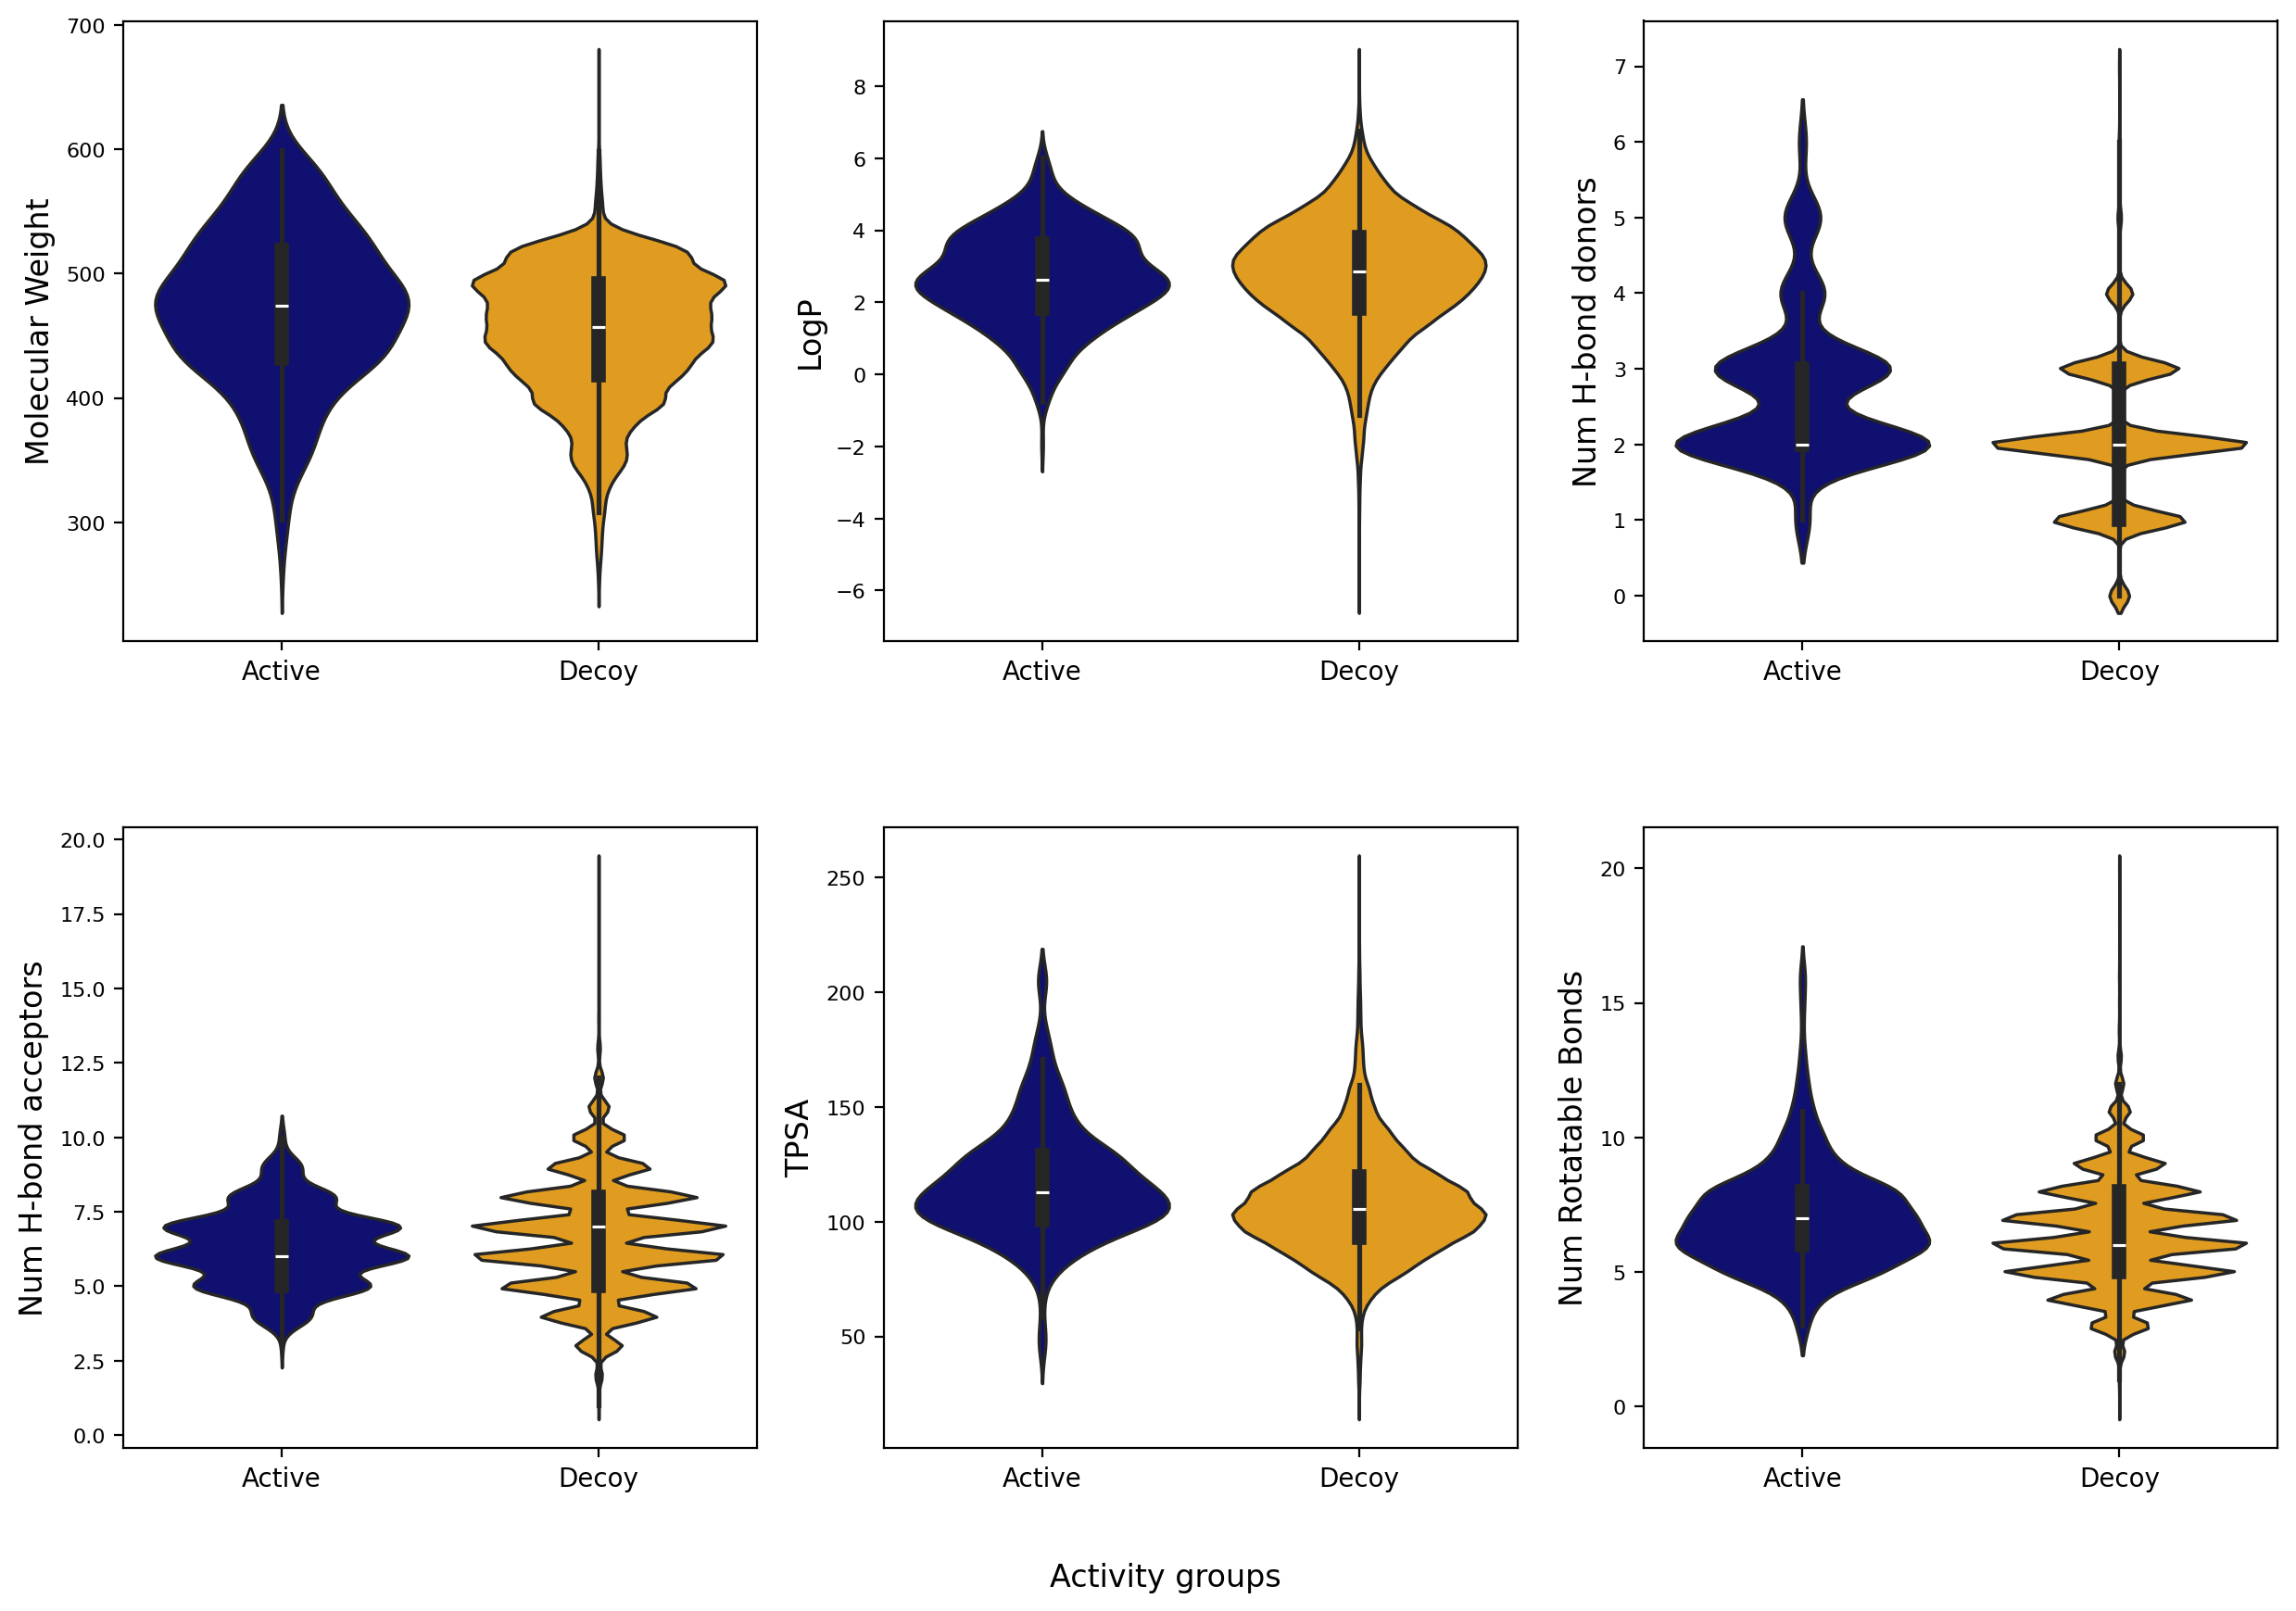

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of properties to plot
properties = ["mw", "logP", "num_hbd", "num_hba", "tpsa", "num_rotatable"]
property_names = ["Molecular Weight", "LogP", "Num H-bond donors", "Num H-bond acceptors", "TPSA", "Num Rotatable Bonds"]

# Setting up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)  # Adjust the spacing between subplots for clarity

# Loop through each property and plot
for i, prop in enumerate(properties):
    ax = axes[i//3, i%3]
    sns.violinplot(x=tmp_df["label"], y=tmp_df[prop], palette=["navy",'orange'], ax=ax)
    ax.set_ylabel(property_names[i], size='large')
    ax.tick_params(axis='y', labelsize=8)

    # Remove individual x-labels
    ax.set_xlabel('')

# Set a single x-label for the entire figure
fig.text(0.5, 0.04, 'Activity groups', ha='center', va='center', size='large')
#fig.tight_layout()

# Save the full figure to a JPEG file
#fig.savefig('ada17_figure_properties.jpg', format='jpeg', dpi=500)

# Display the plots
plt.show()

In [ ]:
# save to a file
combined_df.to_csv("dude_ada17_mk01.csv")

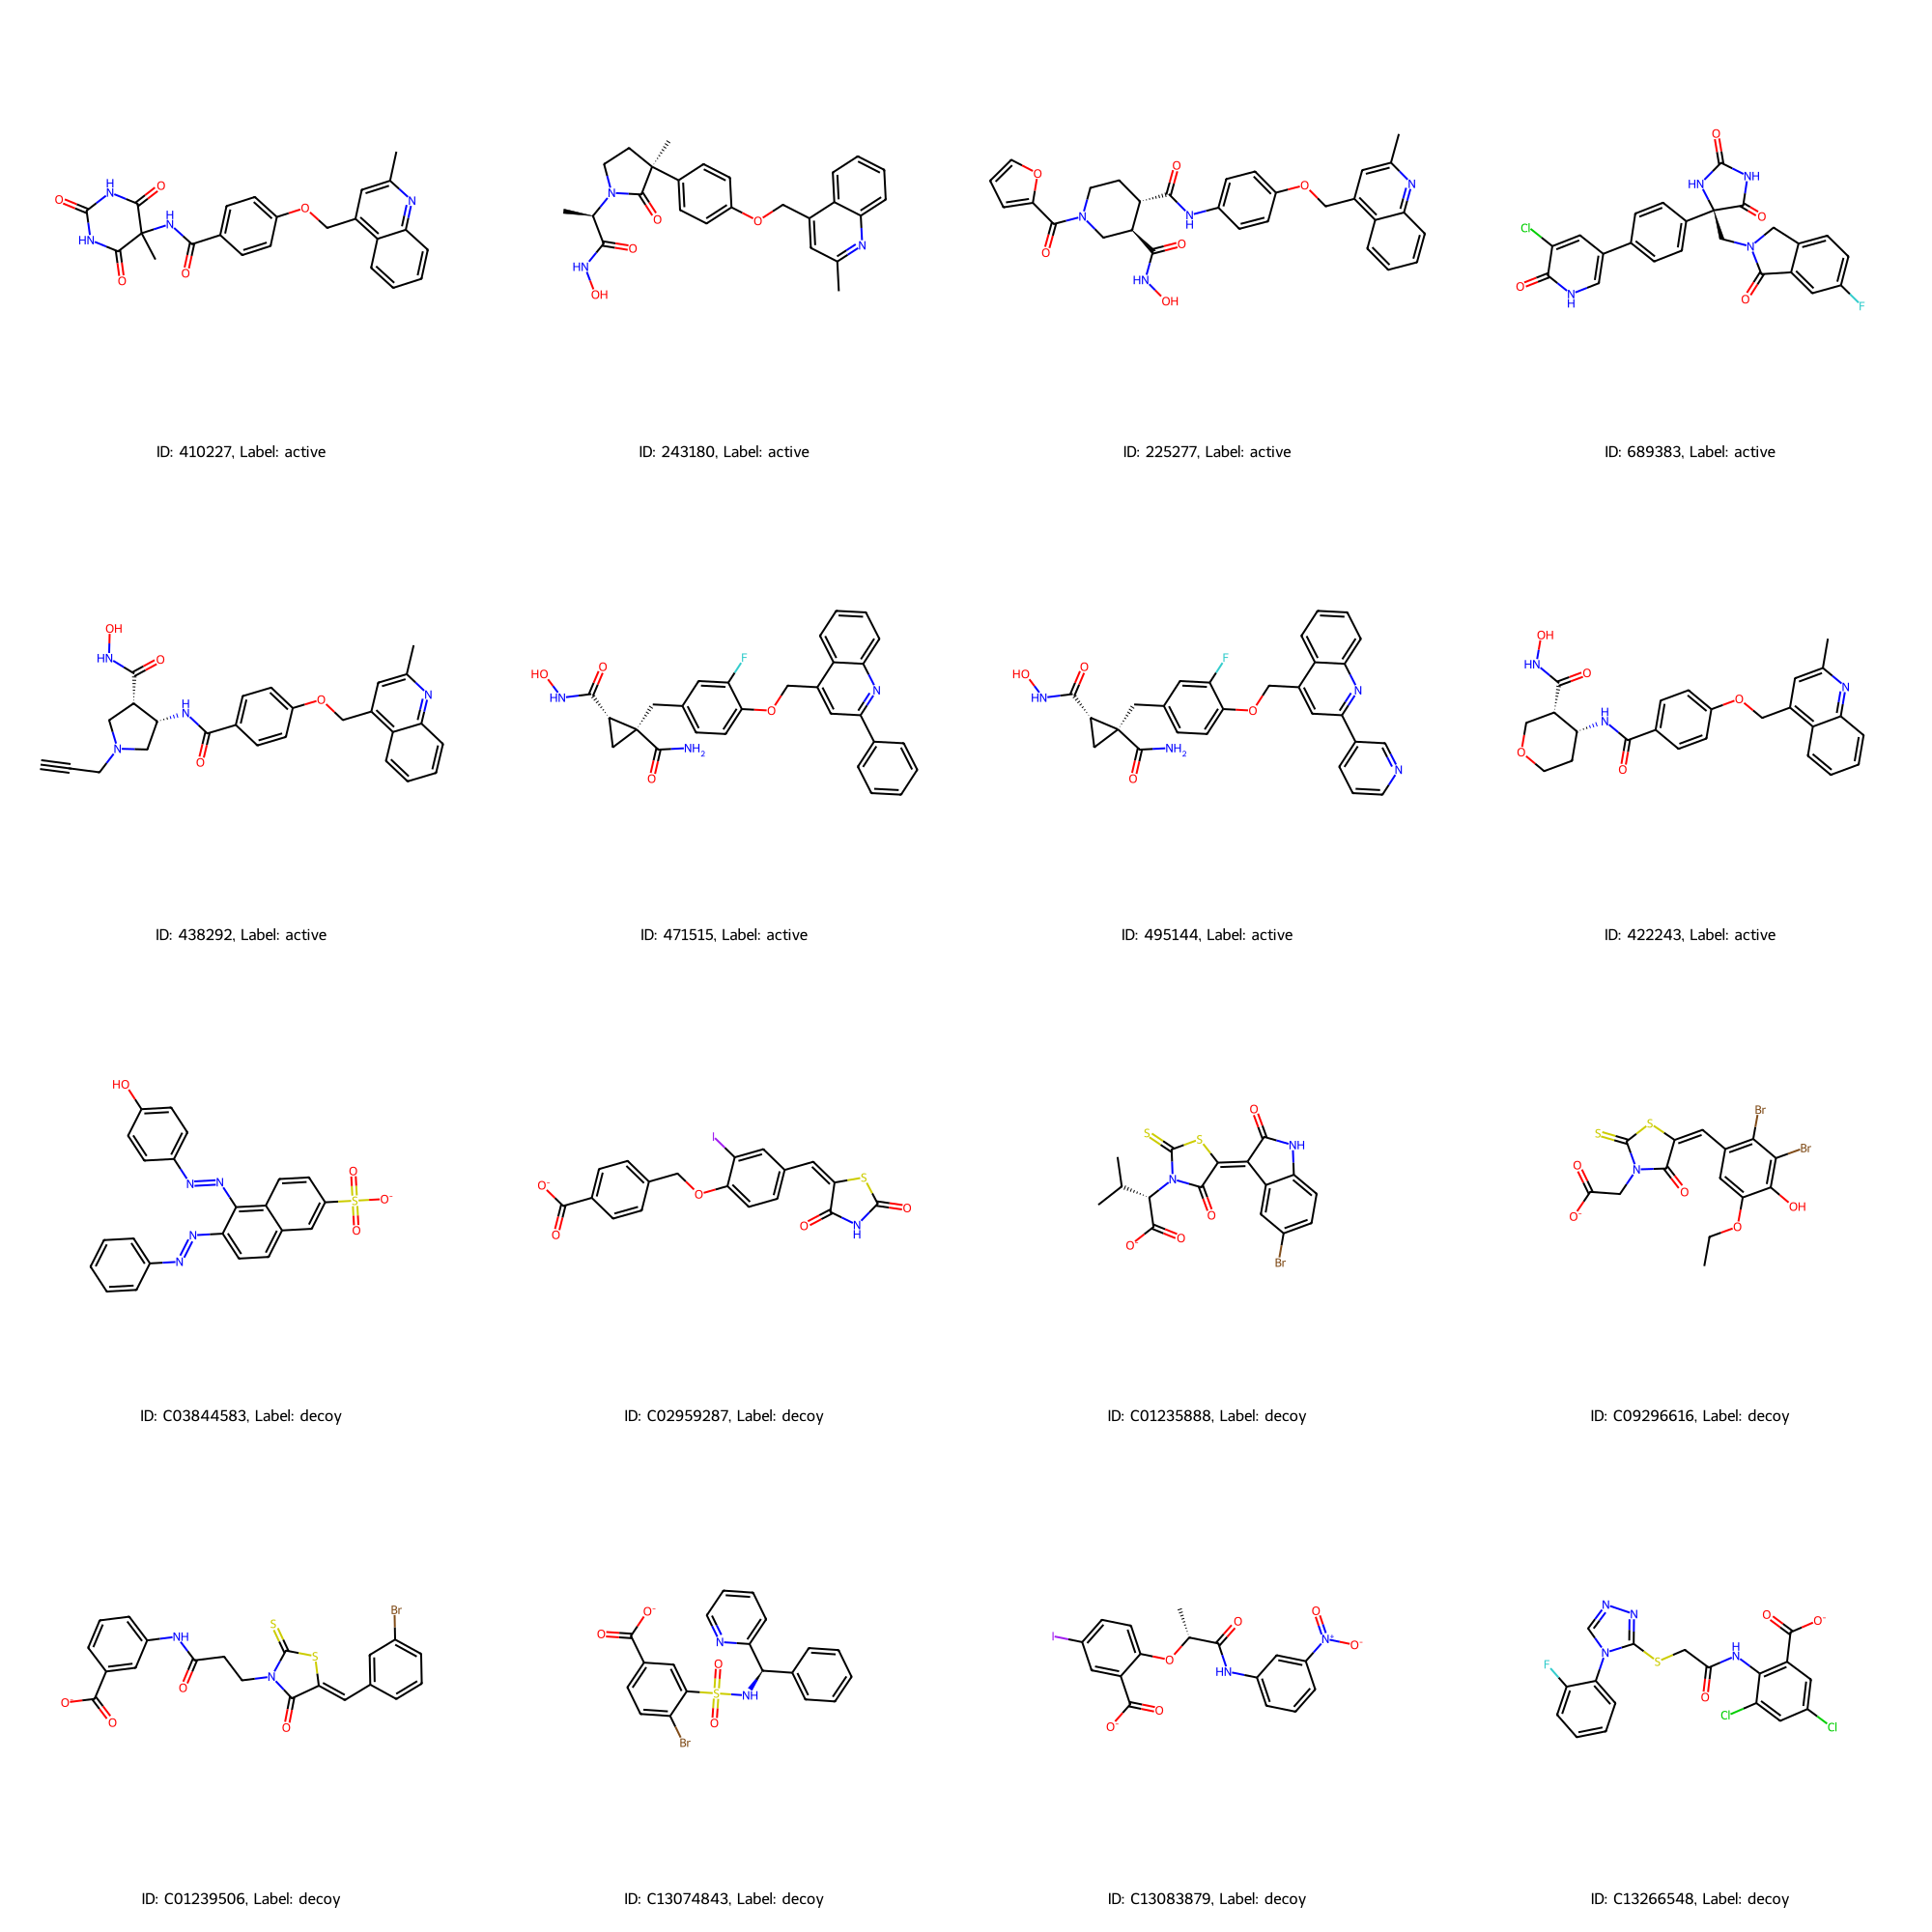

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import Chem

# Filter to get 8 active and 8 decoy molecules
active_molecules = combined_df[combined_df['is_active'] == 1].head(8)
decoy_molecules = combined_df[combined_df['is_active'] == 0].head(8)

# Combine the two sets
selected_molecules = pd.concat([active_molecules, decoy_molecules])

# Convert SMILES to RDKit mol objects
ms = [Chem.MolFromSmiles(smi) for smi in selected_molecules['SMILES']]

# Generate the legends
legends = [f"ID: {id}, Label: {'active' if active == 1 else 'decoy'}" for id, active in zip(selected_molecules['ID'], selected_molecules['is_active'])]

# Draw the molecules
img=Draw.MolsToGridImage(ms, molsPerRow=4, subImgSize=(500,500), legends=legends, returnPNG=False)

# Display the image
img

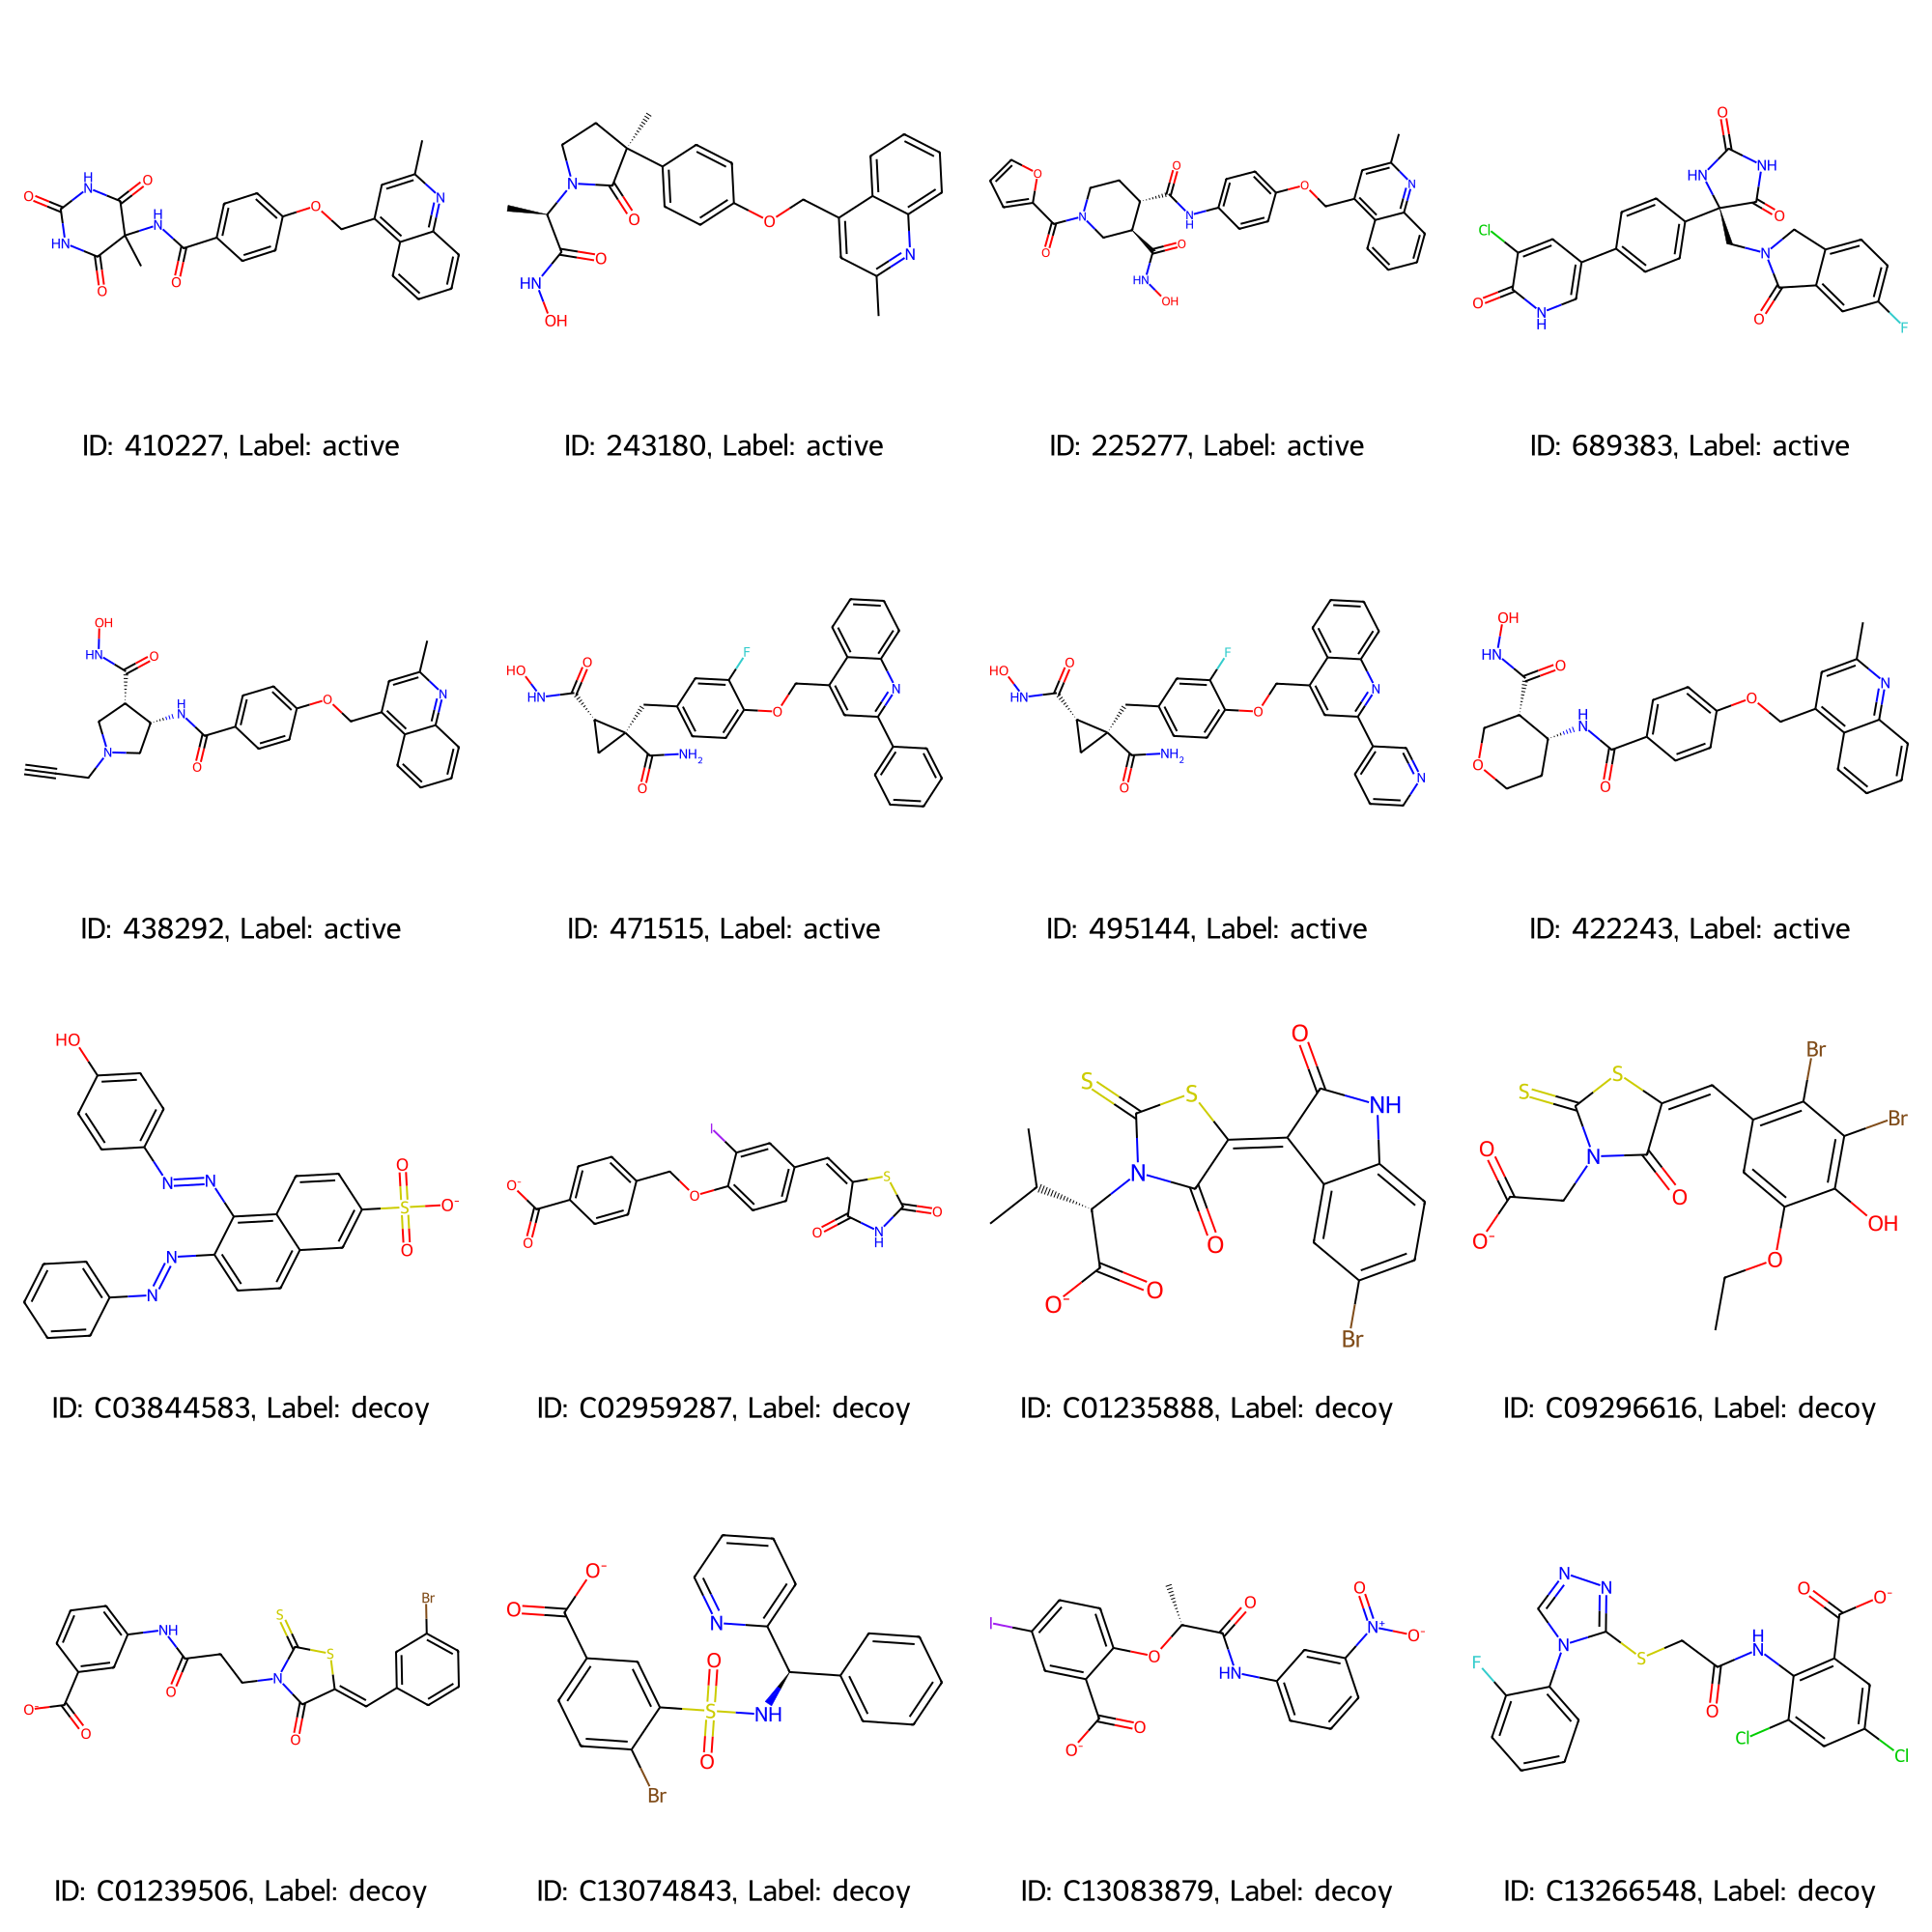

In [ ]:
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import MolDraw2DCairo
import pandas as pd
import io
from PIL import Image
from IPython.display import display

# Create a drawing function
def draw_molecules_with_custom_legends(mols, legends, molsPerRow=4, subImgSize=(500, 500), legendFontSize=30):
    numRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow: numRows += 1

    fullSize = (molsPerRow * subImgSize[0], numRows * subImgSize[1])
    drawer = MolDraw2DCairo(fullSize[0], fullSize[1], subImgSize[0], subImgSize[1])

    opts = drawer.drawOptions()
    opts.legendFontSize = legendFontSize

    for i, mol in enumerate(mols):
        drawer.SetOffset(int(i % molsPerRow) * subImgSize[0], int(i / molsPerRow) * subImgSize[1])
        drawer.DrawMolecule(mol, legend=legends[i])

    drawer.FinishDrawing()
    return drawer.GetDrawingText()

# Draw the molecules
img_data = draw_molecules_with_custom_legends(ms, legends)
img = Image.open(io.BytesIO(img_data))

# Display the image
display(img)

# GraphConvModel

- Graph convolutional network (GCN)

In [ ]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size,
             mode='classification', model_dir="./model_dir")
    return model

In [ ]:
dataset_file = "dude_ada17_mk01.csv"
tasks = ['is_active']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

In [ ]:
dataset

<DiskDataset X.shape: (36432,), y.shape: (36432, 1), w.shape: (36432, 1), task_names: ['is_active']>

# RandomSplitter()
## metric: Matthews Correlarions Coefficients(MCC)

In [ ]:
random_seed = 42
splitter = dc.splits.RandomSplitter()
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5

for i in tqdm(range(0, cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, seed=random_seed) #8:1:1 default
    model.fit(train_dataset)

    # Evaluate training scores and append to list
    train_scores_dict= model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores_dict["mean-matthews_corrcoef"])

    # Evaluate validation scores and append to list
    validation_scores_dict= model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores_dict["mean-matthews_corrcoef"])

    # Get predicted values (continuous output) for both training and validation datasets
    train_pred_values= model.predict(train_dataset)
    val_pred_values= model.predict(valid_dataset)

    train_pred_values = np.squeeze(train_pred_values)[:, 1]
    val_pred_values = np.squeeze(val_pred_values)[:, 1]


    print(train_pred_values.shape)
    print(val_pred_values.shape)

     # Extract true labels for training dataset
    y_true_train_labels=train_dataset.y[:, 0]

     # Extract true labels for validation dataset
    y_true_val_labels=valid_dataset.y[:, 0]

  0%|          | 0/5 [00:00<?, ?it/s]

(29145,)
(3643,)
(29145,)
(3643,)
(29145,)
(3643,)
(29145,)
(3643,)
(29145,)
(3643,)


In [ ]:
validation_score_list

[1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
training_score_list

[1.0, 1.0, 1.0, 1.0, 1.0]

Text(0, 0.5, ' Matthews Correlarions Coefficients')

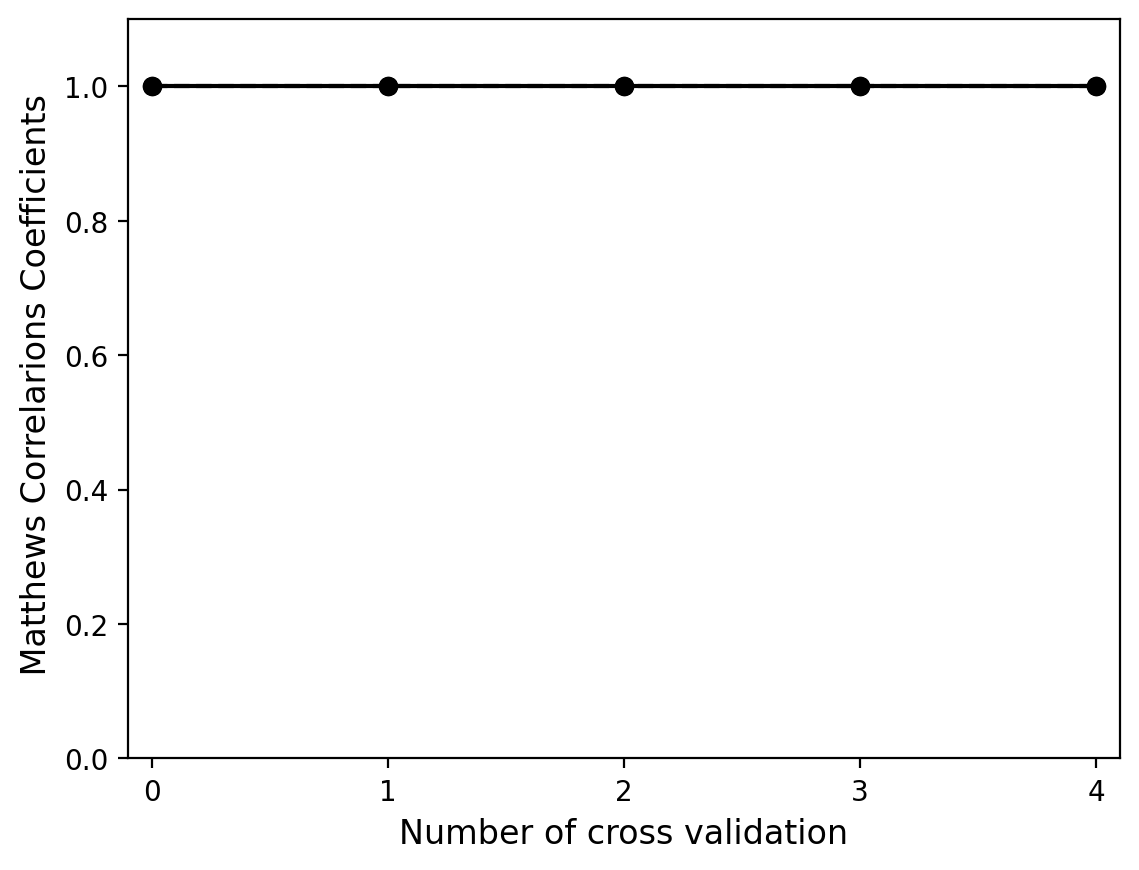

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_score_list, '-o', color='k')
plt.plot(validation_score_list, '--o', color='k')
plt.ylim(0, 1.2)
plt.xlim(-0.1, 4.1)
plt.xticks(range(0,5))
plt.ylim(0, 1.1)
plt.xlabel('Number of cross validation', size='large')
plt.ylabel(' Matthews Correlarions Coefficients', size='large')
#plt.savefig("TACE_training_mcc.jpg")

In [ ]:
np.array(training_score_list).mean(), np.array(validation_score_list).mean()

(1.0, 1.0)

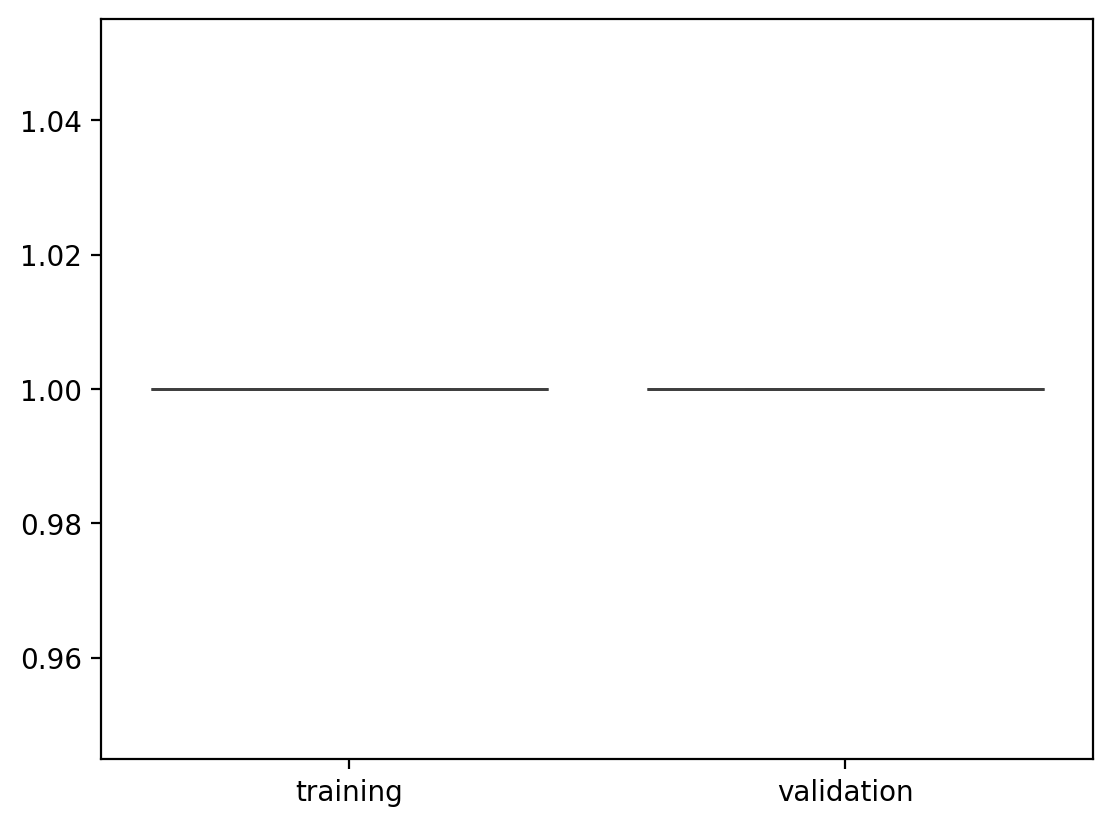

In [ ]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);
#plt.savefig('TACE_figure_validation.jpg')

## Validation dataset prediction

In [ ]:
pred = [x.flatten() for x in model.predict(valid_dataset)] # valid_dataset
pred[:3]

[array([9.9999845e-01, 1.5931219e-06], dtype=float32),
 array([9.9998617e-01, 1.3886443e-05], dtype=float32),
 array([9.9999642e-01, 3.6136023e-06], dtype=float32)]

In [ ]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids
pred_df.head(10).to_csv("prediction_sample.csv")
pred_df.head(10)

,neg,pos,active,SMILES
0,0.999998,0.000002,0,c1ccc(c(c1)c2nnn(n2)CC(=O)N(c3ccc4c(c3)OCCO4)[...
1,0.999986,0.000014,0,c1cc(ccc1NS(=O)(=O)c2ccc3c(c2)OCCO3)NS(=O)(=O)...
2,0.999996,0.000004,0,C[C@H](C(=O)Nc1c(c2c(s1)CCC2)C(=O)N)N3CC[NH+](...
3,0.999998,0.000002,0,COc1ccc(cc1OC)C(=O)CSc2nnc(n2N)c3c4c(n[nH]3)CCC4
4,0.999998,0.000002,0,c1ccc2=[NH+]CC(=c2c1)C3=NN[C@@H](O3)SCC(=O)NC[...
5,0.999997,0.000003,0,c1ccc(cc1)n2c(nnn2)SCC(=O)N/N=C/c3ccc(o3)c4ccc...
6,0.999970,0.000030,0,Cc1c(cc(o1)/C=C/C(=O)Nc2cc(ccc2n3cccn3)C(F)(F)...
7,0.999994,0.000006,0,CC(=O)N[C@H]1C(=O)NC(=NC1=O)SCC(=O)Nc2c(c3c(s2...
8,0.999996,0.000004,0,Cc1cccc(c1NC(=O)[C@H](C)Sc2nnc(n2N)c3ccccc3OC)...
9,0.999992,0.000008,0,CC(C)(C)[C@@H]1CCc2c(sc(c2C(=O)NC3CC3)NC(=O)CC...


In [ ]:
len(pred_df)

3643

In [ ]:
validation_confirm = pred_df.sort_values("pos",ascending=False).head(15)
validation_confirm = validation_confirm.reset_index(drop=True)
validation_confirm.index = validation_confirm.index + 1
#validation_confirm.to_csv("valid_dataset_confirm.csv")
validation_confirm

,neg,pos,active,SMILES
1,0.000004,0.999996,1,C[C@@H](N4CC[C@@](C)(c3ccc(OCc1cc(C)nc2ccccc12...
2,0.000024,0.999976,1,CC#CCOc3ccc(S(=O)(=O)N2CCN(Cc1cccnc1)CC2C(=O)N...
3,0.000025,0.999975,1,CC#CCOc3ccc(S(=O)(=O)N2CCCN(S(=O)(=O)c1ccccc1)...
4,0.000025,0.999975,1,Cc4cc(COc2ccc(C(=O)N[C@@H]1COCC[C@@H]1C(=O)NO)...
5,0.000026,0.999974,1,Cc4cc(COc2ccc(C(=O)N[C@@H]1CNCC[C@@H]1C(=O)NO)...
6,0.000028,0.999972,1,ONC(=O)[C@H]1C[C@@]16CC(c5ccc(OCc3cc(c2ccncc2)...
7,0.000031,0.999969,1,Cc5cc(COc3ccc(NC(=O)[C@H]2CN(C(=O)c1ccco1)CC[C...
8,0.000032,0.999968,1,CC#CCOc2ccc(S(=O)(=O)N1CCCN(C(C)=O)CC1C(=O)NO)cc2
9,0.000042,0.999958,1,COc2cccc3c(N(C)S(=O)(=O)c1ccc(OCC#CC)cc1)c(C(=...
10,0.000055,0.999945,1,Cc5cc(COc3ccc(NC(=O)[C@H]2CCN(C(=O)OCc1cscn1)C...


Text(0.5, 0, 'Experimental activity')

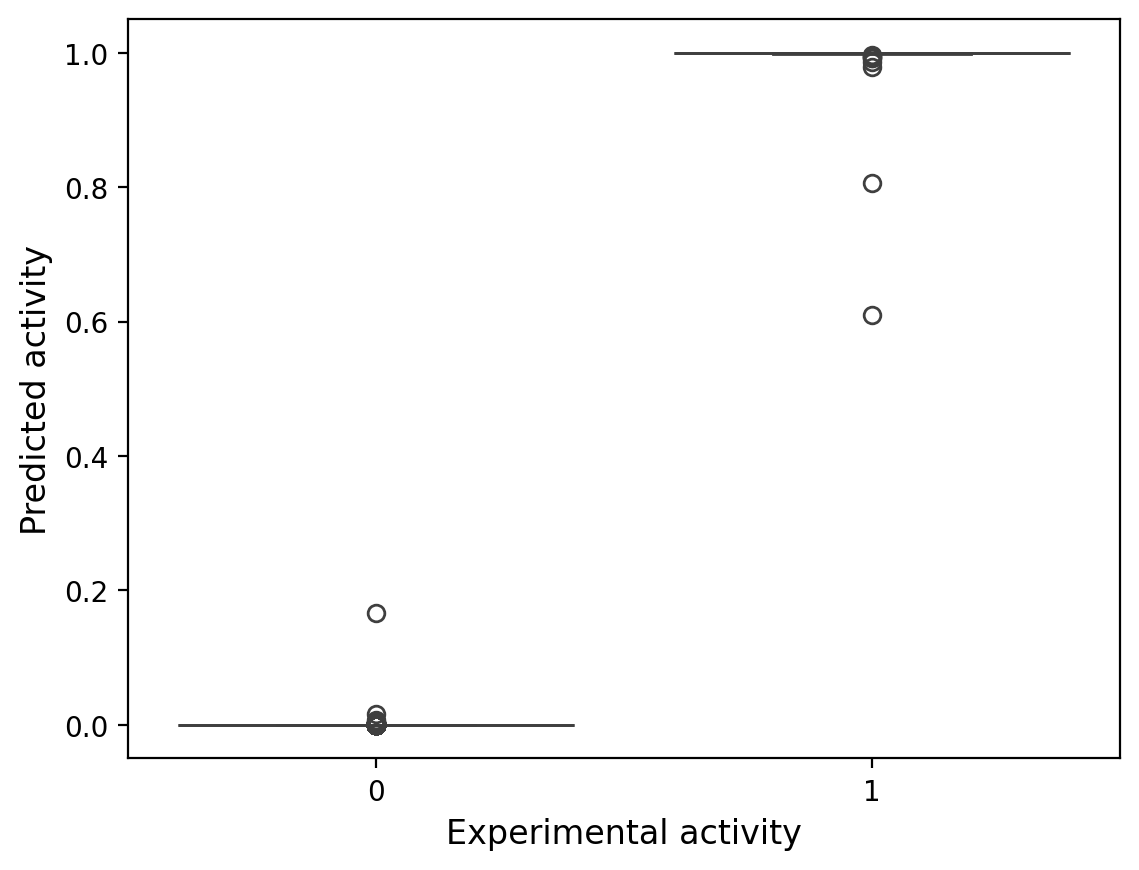

In [ ]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)
plt.ylabel("Predicted activity", size='large')
plt.xlabel('Experimental activity', size='large')
#plt.savefig('figure_validation_set_predition.jpg')

## False Negative compounds

In [ ]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

In [ ]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")
false_negative_df

,neg,pos,active,SMILES,Mol


In [ ]:
len(false_negative_df)

0

## False Positive compounds

In [ ]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")
false_positive_df

,neg,pos,active,SMILES,Mol


In [ ]:
len(false_positive_df)

0

## Test data prediction

In [ ]:
pred = [x.flatten() for x in model.predict(test_dataset)]
pred[:3]

[array([9.9993896e-01, 6.1039987e-05], dtype=float32),
 array([9.9999082e-01, 9.2137825e-06], dtype=float32),
 array([9.9998391e-01, 1.6146278e-05], dtype=float32)]

In [ ]:
test_df = pd.DataFrame(pred,columns=["neg","pos"])
test_df["active"] = [int(x) for x in test_dataset.y]
test_df["SMILES"] = test_dataset.ids
test_df.head(10)

,neg,pos,active,SMILES
0,0.999939,6.103999e-05,0,C[C@@H](C(=O)[O-])n1c(nnc1SCC(=O)N(C)C[C@H]2CO...
1,0.999991,9.213783e-06,0,CC(C)[NH+](Cc1ccccc1)[C@@H](c2cccc(c2OC)OC)c3c...
2,0.999984,1.614628e-05,0,Cc1ccc(c(c1)c2c(c[nH]n2)C[NH+]3CCN([C@@H](C3)C...
3,0.999987,1.257218e-05,0,C[C@@H]1CCc2c(sc3c2c4nnc(n4c(n3)C5CC5)SCC(=O)N...
4,1.000000,1.271513e-07,0,Cc1c(sc2c1c(=O)[nH]c(n2)CS[C@H](C)C(=O)Nc3cc(c...
5,0.999842,1.578399e-04,0,Cc1c2cc(ccc2sc1C(=O)[C@@H](C#N)c3ccccn3)F
6,0.999999,8.452246e-07,0,CC[C@H](C)c1ccccc1NC(=O)[C@@H](C)OC(=O)c2cc(cc...
7,0.999924,7.613783e-05,0,CCN(CC)S(=O)(=O)c1cc(ccc1Cl)C(=O)NNC(=O)c2cc(c...
8,0.999997,3.513853e-06,0,CC[C@@H](CO)Nc1c(c(=O)n2ccccc2n1)/C=C\3/C(=O)N...
9,0.999992,7.816782e-06,0,COC(=O)CNC(=O)Cc1ccc(cc1)NC(=O)c2ccc3c(c2)nc4n...


In [ ]:
len(test_df)

3644

In [ ]:
test_confirm = test_df.sort_values("pos",ascending=False).head(15)
test_confirm = test_confirm.reset_index(drop=True)
test_confirm.index = test_confirm.index + 1
test_confirm

,neg,pos,active,SMILES
1,0.000015,0.999985,1,Cc4cc(COc2ccc(CN1C(C(=O)NO)CCS1(=O)=O)cc2)c3cc...
2,0.000032,0.999968,1,Cc5cc(COc3ccc(C(=O)N[C@@H]2CN(C1CCC1)C[C@@H]2C...
3,0.000034,0.999966,1,CC#CCOc3ccc(S(=O)(=O)N2CCN(C(=O)c1cccs1)CC2C(=...
4,0.000035,0.999965,1,Cc4cc(COc2ccc(S(=O)(=O)CC1CNCCC1C(=O)NO)cc2)c3...
5,0.000035,0.999965,1,Cc4cc(COc2ccc(C(=O)NCC1(C(=O)NO)CCN(S(C)(=O)=O...
6,0.000038,0.999962,1,Cc5cc(COc3ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc1ccncc...
7,0.000045,0.999955,1,Cc4cc(COc2ccc(C(=O)N[C@@H]1CC(=O)C[C@@H]1C(=O)...
8,0.000049,0.999951,1,Cc5cc(COc3ccc(C(=O)N[C@@H]2CN(Cc1ccccc1)C[C@@H...
9,0.000050,0.999950,1,CN(c1c(C)cc(Br)cc1C(=O)NO)S(=O)(=O)c4ccc(c3ccc...
10,0.000058,0.999942,1,CNCCOc2ccc([C@@H](NS(=O)(=O)c1ccc(OCC#CC)cc1)C...


Text(0.5, 0, 'Experimental activity')

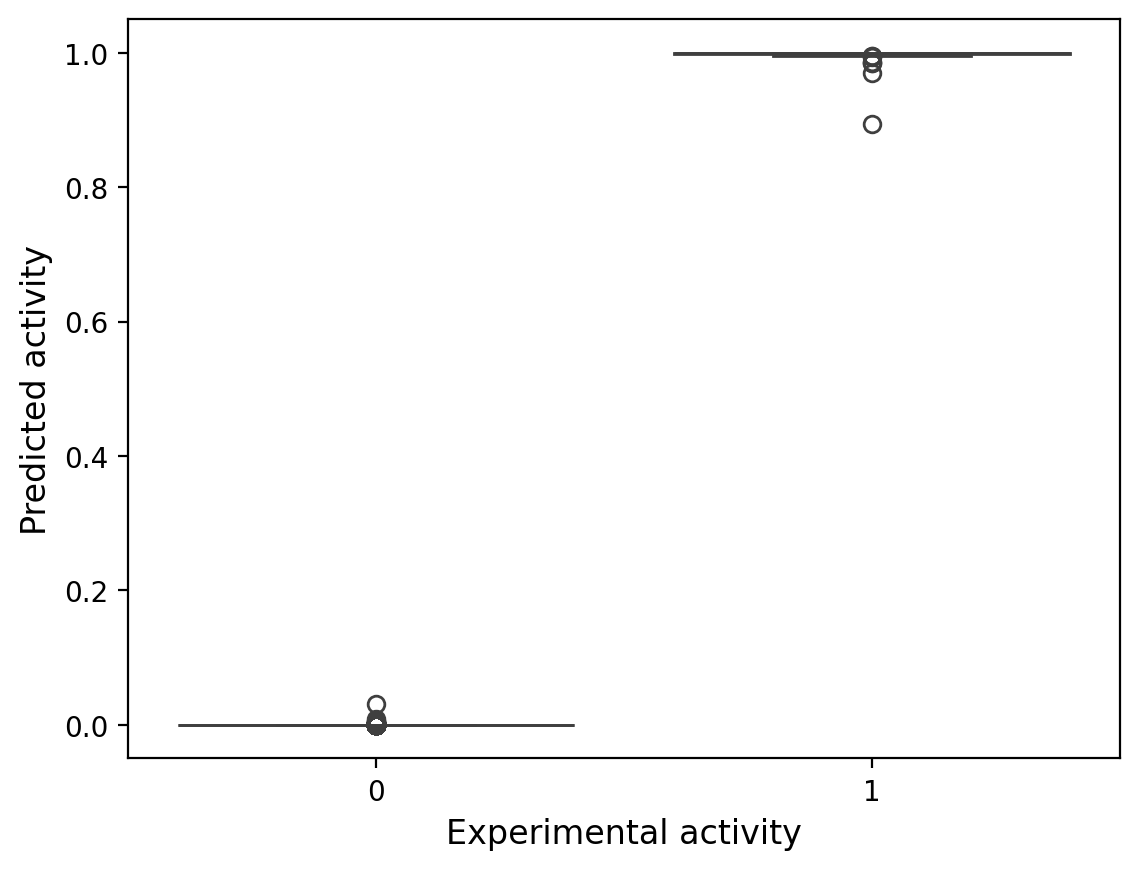

In [ ]:
sns.boxplot(x=test_df.active,y=test_df.pos)
plt.ylabel("Predicted activity", size='large')
plt.xlabel('Experimental activity', size='large')

In [ ]:
false_negative_df = test_df.query("active == 1 & pos < 0.5").copy()

In [ ]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")
false_negative_df

,neg,pos,active,SMILES,Mol


In [ ]:
len(false_negative_df)

0

## False Positive

In [ ]:
false_positive_df = test_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")
false_positive_df

,neg,pos,active,SMILES,Mol


In [ ]:
len(false_positive_df)

0

## GraphConvModel fit

In [ ]:
model.fit(dataset)

8.103554913153251e-05

## rd_filters

rd_filters is a Python package created by Pat Walters for cheminformatics purposes. It is used to filter chemical structures based on various criteria, such as substructure filters, physicochemical properties, and custom rules. This package is especially useful for ensuring that chemical libraries adhere to specific guidelines or constraints, which can be important in drug discovery and other fields of chemistry.
- [rd_filters github](https://github.com/PatWalters/rd_filters)

In [ ]:
!pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-juphvwbe
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-juphvwbe
  Resolved https://github.com/PatWalters/rd_filters.git to commit 3630f1a59150b4a203c2f06d8376a66d1d4c3f70
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for rd_filters: filename=rd_filters-0.1-py3-none-any.whl size=33862 sha256=43b9735e6be7afcb96a99a88e3f6f2f9647bbb9cb40b1929d71818e6a9351e7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-0oz1som0/wheels/1d/57/d3/243da16d0396df21d623d6c41bcae207900be0f3f1a4e3224f
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=3874f20776f7e179159fe8b898d3ff229a909030a586955474aa4250f0e7d41d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built rd_filters docopt


## Target small molecule library (ex. FDA-approved compounds)

In [ ]:
import csv

# Open the CSV file for reading
with open('/content/FDA_approved_drug_dataset.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)

    # Open the SMI file for writing
    with open('fda_approved.smi', 'w') as smi_file:
        # Loop through each row in the CSV file
        for row in reader:
            # Write the SMILES string to the SMI file
            smi_file.write(row[0] + '  fda' +'\n')

In [ ]:
!rd_filters filter --in /content/fda_approved.smi  --prefix fda

using 2 cores
Using alerts from Inpharmatica
[07:04:39] SMILES Parse Error: syntax error while parsing: SMILES
[07:04:39] SMILES Parse Error: Failed parsing SMILES 'SMILES' for input: 'SMILES'
Wrote SMILES for molecules passing filters to fda.smi
Wrote detailed data to fda.csv
1414 of 3084 passed filters 45.8%
Elapsed time 3.38 seconds


In [ ]:
df = pd.read_csv("fda.csv")
df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,SMILES,fda,INVALID,-999.000,-999.0000,-999,-999,-999.00,-999
1,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,fda,OK,386.480,4.6391,2,4,70.67,5
2,Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21,fda,OK,457.687,3.5256,3,6,88.41,6
3,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,fda,OK,539.636,3.6159,2,7,94.22,7
4,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cncc...,fda,Filter9_metal > 0,384.245,0.3606,4,6,124.44,9


In [ ]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
1,OK,2098
4,Filter44_michael_acceptor2 > 0,318
5,Filter82_pyridinium > 0,147
2,Filter9_metal > 0,78
9,Filter14_thio_oxopyrylium_salt > 0,72


In [ ]:
print(len(count_df))

45


# Model application

In [ ]:
df = pd.read_csv("fda.smi",sep=" ",header=None)
df.columns=["SMILES","Name"]
rows,cols = df.shape
df["Val"] = [0] * rows
df.head()

,SMILES,Name,Val
0,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,fda,0
1,Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21,fda,0
2,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,fda,0
3,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,fda,0
4,Nc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O,fda,0


In [ ]:
print(len(df))

1414


In [ ]:
infile_name = "fda_filtered.csv"
df.to_csv(infile_name,index=False)

In [ ]:
loader = dc.data.CSVLoader(tasks=['Val'], feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(infile_name, shard_size=8192)
pred = model.predict(dataset)

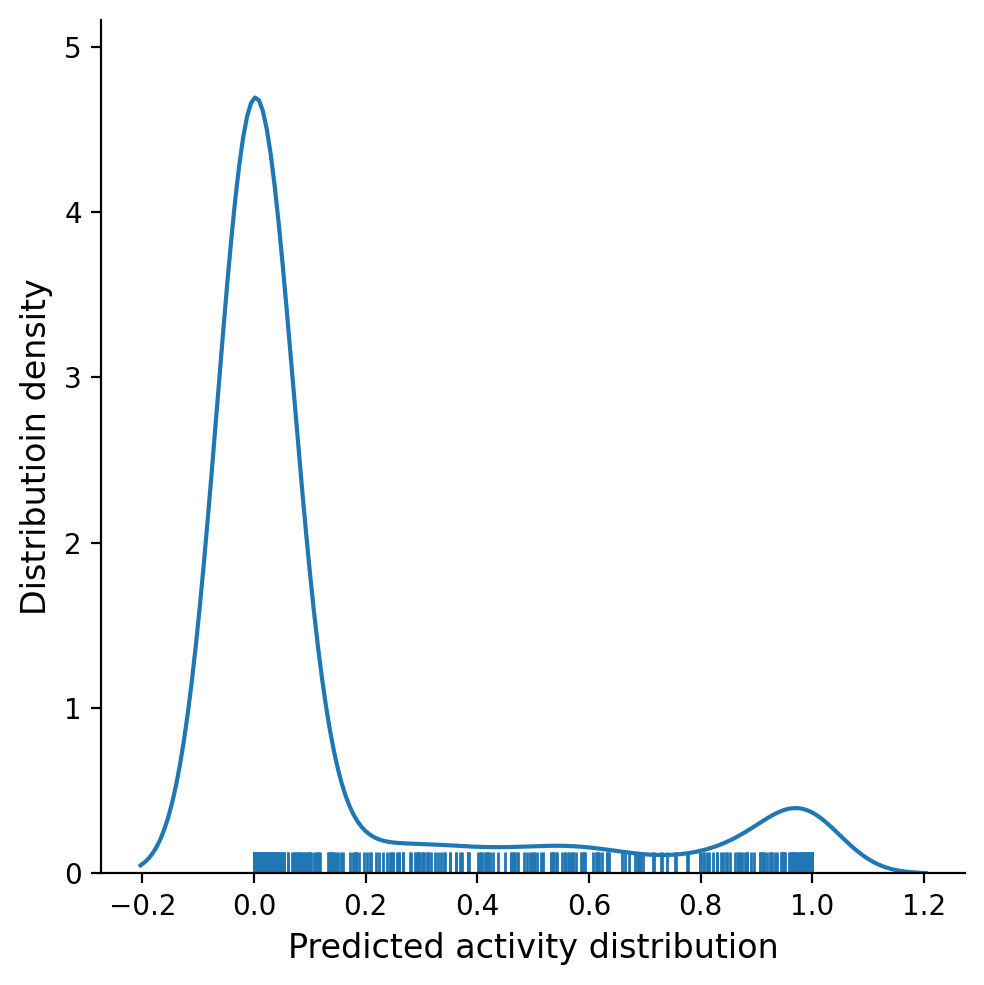

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])
sns.displot(x=pred_df.Pos, kind="kde", rug=True)
plt.xlabel('Predicted activity distribution', size='large')
plt.ylabel('Distributioin density', size='large')
plt.savefig("fda_prediction_distribution.jpg", dpi=600)

In [ ]:
combo_df = df.join(pred_df,how="outer")
combo_df.sort_values("Pos",inplace=True,ascending=False)

In [ ]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")
combo_df.head()

,SMILES,Name,Val,Neg,Pos,Mol
1298,Cl.N[C@@H](Cc1cnc[nH]1)C(=O)O.O,fda,0,0.000019,0.999981,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fa70>
584,CC(=O)NO,fda,0,0.000022,0.999978,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fbc0>
44,NC(=O)NO,fda,0,0.000032,0.999969,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd80>
278,Cl.N=C(N)NC(=N)NCCc1ccccc1,fda,0,0.000074,0.999926,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fc30>
426,Cl.N=C(N)N,fda,0,0.000083,0.999917,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd10>


In [ ]:
print(len(combo_df))

1414


In [ ]:
combo_df[:15]

,SMILES,Name,Val,Neg,Pos,Mol
1298,Cl.N[C@@H](Cc1cnc[nH]1)C(=O)O.O,fda,0,0.000019,0.999981,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fa70>
584,CC(=O)NO,fda,0,0.000022,0.999978,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fbc0>
44,NC(=O)NO,fda,0,0.000032,0.999969,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd80>
278,Cl.N=C(N)NC(=N)NCCc1ccccc1,fda,0,0.000074,0.999926,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fc30>
426,Cl.N=C(N)N,fda,0,0.000083,0.999917,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd10>
241,O=C([O-])C(O)Cc1ccc(O)c(O)c1.[Na+],fda,0,0.000088,0.999912,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fdf0>
1077,CC(O)C(=O)[O-].[NH4+],fda,0,0.000091,0.999909,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fe60>
327,CNCCc1ccccn1.Cl.Cl,fda,0,0.000094,0.999906,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fed0>
1194,C[C@H](O)C(=O)[O-].[Na+],fda,0,0.000117,0.999883,<rdkit.Chem.rdchem.Mol object at 0x78ebcefa0040>
197,CCCCOc1ccc(CC(=O)NO)cc1,fda,0,0.000151,0.999849,<rdkit.Chem.rdchem.Mol object at 0x78ebcefa00b0>


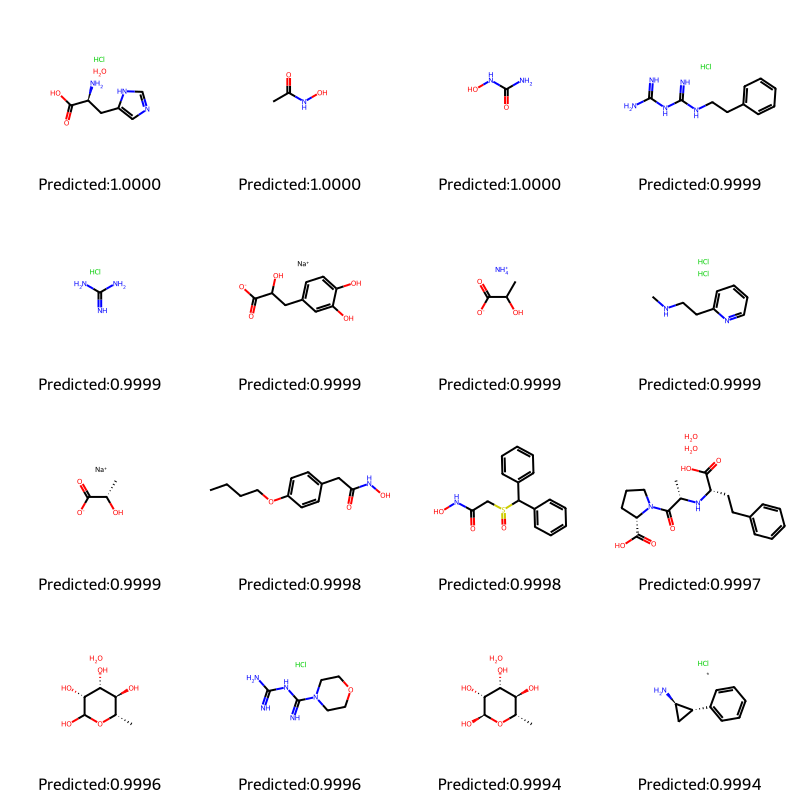

In [ ]:
img=Draw.MolsToGridImage(combo_df.Mol[:16],molsPerRow=4,legends=["Predicted:%.4f" % x for x in combo_df.Pos[:16]], returnPNG=False)
#img.save("predicted_activity.jpg")
img

In [ ]:
best_100_df = combo_df.head(100).copy()
best_100_df[:5]

,SMILES,Name,Val,Neg,Pos,Mol
1298,Cl.N[C@@H](Cc1cnc[nH]1)C(=O)O.O,fda,0,0.000019,0.999981,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fa70>
584,CC(=O)NO,fda,0,0.000022,0.999978,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fbc0>
44,NC(=O)NO,fda,0,0.000032,0.999969,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd80>
278,Cl.N=C(N)NC(=N)NCCc1ccccc1,fda,0,0.000074,0.999926,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fc30>
426,Cl.N=C(N)N,fda,0,0.000083,0.999917,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd10>


In [ ]:
best_100_df

,SMILES,Name,Val,Neg,Pos,Mol
1298,Cl.N[C@@H](Cc1cnc[nH]1)C(=O)O.O,fda,0,0.000019,0.999981,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fa70>
584,CC(=O)NO,fda,0,0.000022,0.999978,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fbc0>
44,NC(=O)NO,fda,0,0.000032,0.999969,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd80>
278,Cl.N=C(N)NC(=N)NCCc1ccccc1,fda,0,0.000074,0.999926,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fc30>
426,Cl.N=C(N)N,fda,0,0.000083,0.999917,<rdkit.Chem.rdchem.Mol object at 0x78eb9ce5fd10>
...,...,...,...,...,...,...
655,O=C([O-])c1ccccc1.[Na+],fda,0,0.094249,0.905751,<rdkit.Chem.rdchem.Mol object at 0x78ebcefa2650>
885,CC1(C)S[C@@H]2[C@H](NC(=O)COc3ccccc3)C(=O)N2[C...,fda,0,0.104495,0.895505,<rdkit.Chem.rdchem.Mol object at 0x78ebcefa26c0>
1312,Cl.c1cnc2cc3c(cc2n1)C1CNCC3C1,fda,0,0.109268,0.890732,<rdkit.Chem.rdchem.Mol object at 0x78ebcefa2730>
931,CC(N)C12CC3CC(CC(C3)C1)C2.Cl,fda,0,0.116531,0.883469,<rdkit.Chem.rdchem.Mol object at 0x78ebcefa27a0>


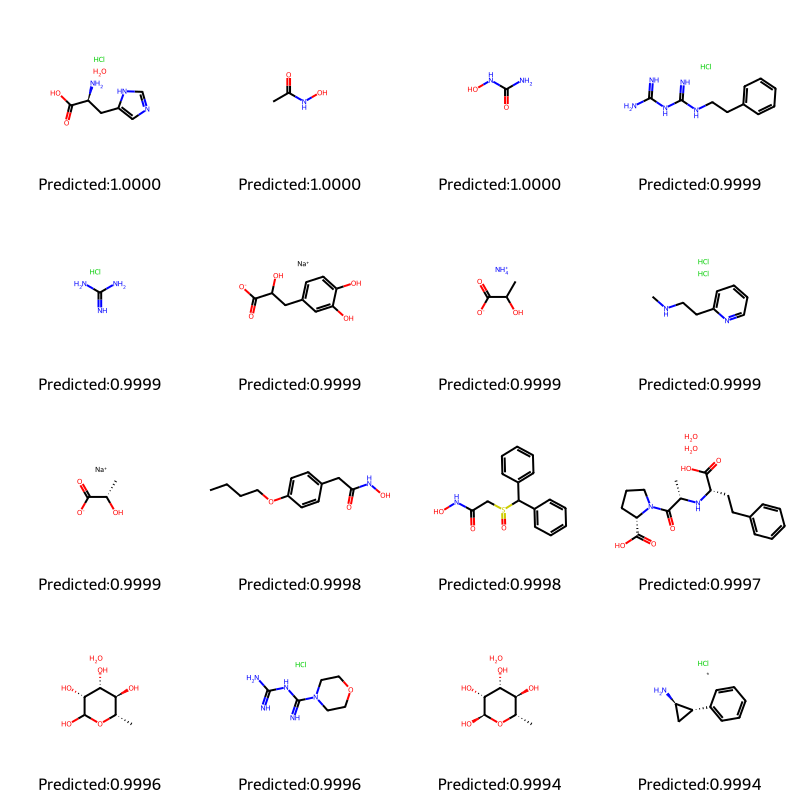

In [ ]:
img=Draw.MolsToGridImage(best_100_df.Mol[:16],molsPerRow=4,legends=["Predicted:%.4f" % x for x in best_100_df.Pos[:16]], returnPNG=False)
#img.save("TACE_redicted_output.jpg")
img

## Save the result

In [ ]:
best_cluster_rep_df.to_csv("TACE_new_best_cluster_represenatives.csv")